___
___
___
# RandomForestClassifier
___
___
___

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# df = pd.read_csv('./data_set/SBAnational-EDA.csv')
df = pd.read_csv('./data_set/SBAnational1000.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1).reset_index(drop=True)

df.columns

Index(['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate',
       'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status',
       'GrAppv', 'SBA_Appv', 'NAICS2', 'DiffJobs'],
      dtype='object')

In [5]:
dd = df.groupby(['ApprovalFY', 'MIS_Status']).size().reset_index(name='count')

# Pivoter les résultats
dd = dd.pivot(index='ApprovalFY', columns='MIS_Status', values='count').reset_index()

# Remplacer les NaN par 0
dd.fillna(0, inplace=True)

# Créer une nouvelle colonne basée sur la comparaison 'CHGOFF' > 'P I F'
dd['ApprovalFY_bool'] = dd.apply(lambda row: 0 if row['CHGOFF'] > row['P I F'] else 1, axis=1)

dd = dd[['ApprovalFY_bool']]

df = pd.concat([df, dd], axis=1)

In [6]:
df = df[[
    'City',
    'State',
    'Zip',
    'Bank',
    'BankState',
    'NAICS',
    # 'NAICS2',
    'ApprovalDate',
    'ApprovalFY',
    # 'ApprovalFY_bool',
    'Term',
    'NoEmp',
    'NewExist',
    'CreateJob',
    'RetainedJob',
    'DiffJobs',
    'FranchiseCode',
    'UrbanRural',
    'RevLineCr',
    'LowDoc',
    'GrAppv',
    'SBA_Appv',
    'MIS_Status',
    ]]

In [7]:
df.head(1).transpose()

,0
City,EVANSVILLE
State,IN
Zip,47711
Bank,FIFTH THIRD BANK
BankState,IN
NAICS,451120
ApprovalDate,1997-02-28
ApprovalFY,1997-01-01
Term,84
NoEmp,4


In [8]:
colonnes_numeriques = df.select_dtypes(include=['number']).columns.tolist()

# Sélectionner les colonnes non numériques
colonnes_non_numeriques = df.drop(columns=colonnes_numeriques).columns.tolist()

print(colonnes_numeriques)
print(colonnes_non_numeriques)

['Zip', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'DiffJobs', 'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv']
['City', 'State', 'Bank', 'BankState', 'ApprovalDate', 'ApprovalFY', 'RevLineCr', 'LowDoc', 'MIS_Status']


In [9]:
# Créer un nouveau DataFrame sans les lignes contenant des valeurs NaN
# df = df.dropna()

# Vérifier s'il y a des valeurs manquantes dans le DataFrame
missing_values = df.isnull().sum()
# Afficher les colonnes avec des valeurs manquantes
print("Colonnes avec des valeurs manquantes :\n", missing_values[missing_values > 0])

# Vérifier les types de données de chaque colonne
# data_types = df.dtypes
# Afficher les types de données de chaque colonne
# print("Types de données de chaque colonne :\n", data_types)

Colonnes avec des valeurs manquantes :
 Series([], dtype: int64)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

grid_search_bool = False

numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Définir le preprocessor
label_encoder = LabelEncoder()
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numerical_features),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='if_binary')), categorical_features),
)

# Prétraiter les données
X = preprocessor.fit_transform(df.drop(columns='MIS_Status'))
y = label_encoder.fit_transform(df['MIS_Status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.05, random_state=42, stratify=y)
# y_train = y_train.astype(int).tolist()
# y_test = y_test.astype(int).tolist()

if grid_search_bool == False:
    # LGBM
    d_train = lgb.Dataset(X_train, label=y_train)

    # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    # best f1 macro : 0.9154           random_state=0, verbose=0, warm_start=False)


    start=datetime.now()
    rf_classifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                criterion='gini', max_depth=None, max_features='sqrt',
                max_leaf_nodes=None, max_samples=None,
                min_impurity_decrease=0.0, min_samples_leaf=1,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=100, n_jobs=-1, oob_score=False,
                random_state=0, verbose=0, warm_start=False)
    rf_classifier.fit(X_train, y_train)
    stop=datetime.now()
    execution_time_rfc = stop-start

    #Prediction on test data
    y_pred = rf_classifier.predict(X_test)

    #convert into binary values 0/1 for classification
    # y_pred_rfc = [list(x).index(max(x)) for x in y_pred]

    print(execution_time_rfc)

0:00:00.331836


#########################################################
      RFC execution time is:  0:00:00.331836
#########################################################
              precision    recall  f1-score    support
0              1.000000  0.142857  0.250000   7.000000
1              0.884615  1.000000  0.938776  46.000000
accuracy       0.886792  0.886792  0.886792   0.886792
macro avg      0.942308  0.571429  0.594388  53.000000
weighted avg   0.899855  0.886792  0.847805  53.000000
#########################################################
                  F1 macro score: 0.5944
#########################################################


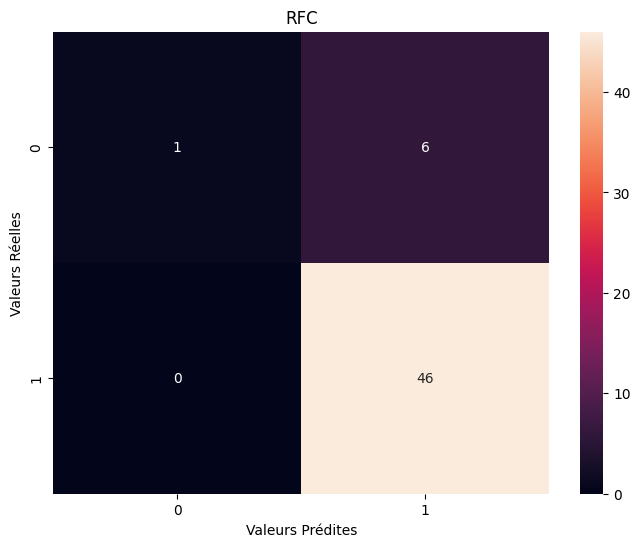

In [11]:
if grid_search_bool == False:
    plt.figure(figsize=(8, 6))
    cm_lgbm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_lgbm, annot=True)
    plt.title("RFC")
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')

    ################
    #SUMMARY
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report)
    print("#########################################################")
    print("      RFC execution time is: ", execution_time_rfc)
    print("#########################################################")
    print(df_report.T)
    print("#########################################################")
    print("                  F1 macro score:", round(report["macro avg"]["f1-score"], 4))
    print("#########################################################")

___
### PICKEL

In [12]:
import pickle

filename = './model/modelRFC.pkl'

with open(filename, 'wb') as file:
    pickle.dump(rf_classifier, file)


FileNotFoundError: [Errno 2] No such file or directory: './model/modelRFC.pkl'

In [ ]:
import pickle

# Charger le modèle à partir du fichier pickle
with open('./model/modelRFC.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Maintenant, vous pouvez utiliser le modèle pour faire des prédictions sur de nouvelles données
# Par exemple, si vous avez de nouvelles données dans X_new, vous pouvez les utiliser comme ceci :
# y_pred = loaded_model.predict(X_new)
# Assurez-vous que les nouvelles données sont prétraitées de la même manière que les données d'entraînement avant de les utiliser pour la prédiction.

# Par exemple, si vous avez un ensemble de données de test comme X_test, vous pouvez prédire comme suit :
y_pred_pkl = loaded_model.predict(X_test)

# Ensuite, vous pouvez évaluer les performances du modèle comme vous l'avez fait précédemment.
y_pred_pkl


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])